In [332]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from functions import build_model, WindowGenerator
import tensorflow as tf
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data cleaning

In [348]:
df = pd.read_csv("data/no1_train.csv")
df_validation = pd.read_csv("data/no1_validation.csv")

percent = 0.005
upper_bound = df.y.quantile(1-percent/2)
lower_bound = df.y.quantile(percent/2)

print("Upper bound:", upper_bound)
print("Lower bound:", lower_bound)
clamped_points = (df.y < lower_bound).sum() + (df.y > upper_bound).sum()

print("Points clamped: %d. In percent %.4f%%" % (clamped_points, (clamped_points / len(df.y)) * 100))
df.y.where(df.y > lower_bound, lower_bound, inplace=True)
df.y.where(df.y < upper_bound, upper_bound, inplace=True)

Upper bound: 1965.4099018235388
Lower bound: -876.8264394156931
Points clamped: 1126. In percent 0.5002%


0.010875746374751208


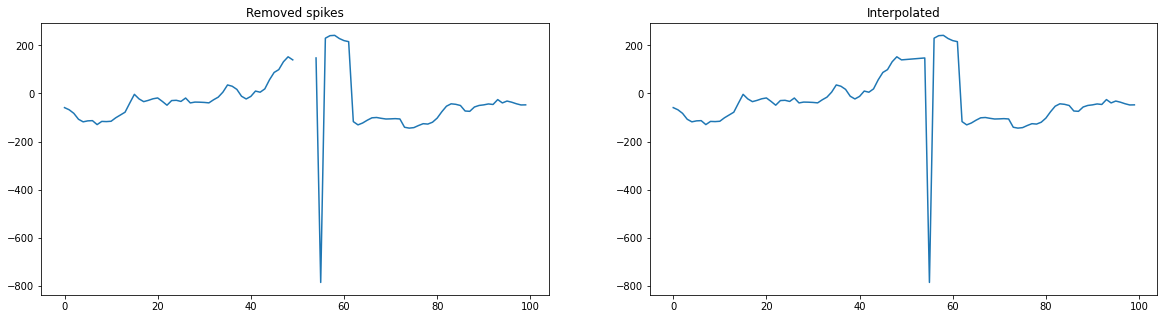

In [349]:
def interpolate_target_data(df_train, df_test, visualise=True):
	min_value = df_train.y.min()
	max_value = df_train.y.max()
	df_copy = df_test.copy()
	print( (len(df_copy) - df_copy.y.between(min_value, max_value).sum()) / len(df_copy))
	df_copy.y.where(df_copy.y.between(min_value, max_value), np.nan, inplace=True)

	if visualise:
		fig, ax = plt.subplots(1,2, figsize=(20,5))
		critical_point = df_test.y.argmin()  # a critical point of y data
		ax[0].plot(df_copy["y"][critical_point-50:critical_point+50].values) # The critical part of y data
		ax[0].set_title("Removed spikes")

		inter_df = df_copy["y"].interpolate(method='linear', inplace=False)
		ax[1].plot(inter_df[critical_point-50:critical_point+50].values)
		ax[1].set_title("Interpolated")
		plt.show()

	df_copy["y"].interpolate(method='linear', inplace=True)
	return df_copy
df_cleaned = interpolate_target_data(df, df_validation, visualise=True)

In [350]:
df_cleaned.y.min(), df_cleaned.y.max(), df_cleaned.y.mean(), df_cleaned.y.std()

(-808.6830238975343, 1223.8083715598814, 16.560563188043776, 165.2672388067725)

## Add features

In [271]:
from functions import add_time_features, add_lag_features

column_indcies = [ 'hydro', 'micro', 'thermal', 'wind', 'total','sys_reg', 'flow', 'Hour sine', 'Day sine', 'Month sine', 'Week sine', 'prev_y_1', 'y',]

train_df = add_time_features(df)
train_df = add_lag_features(df, 1)[column_indcies]

test_df = add_time_features(df_validation)
test_df = add_lag_features(df_validation, 1)[column_indcies]

In [272]:
train_df.head()

,hydro,micro,thermal,wind,total,sys_reg,flow,Hour sine,Day sine,Month sine,Week sine,prev_y_1,y
2,1591.839,141.928,11.5,74.428,1819.695,10.0,-4417.4,-0.5,0.154203,0.5,0.239316,330.114330,323.877221
3,1591.839,141.928,11.5,74.428,1819.695,10.0,-4417.4,-0.5,0.154203,0.5,0.239316,323.877221,296.438463
4,1591.839,141.928,11.5,74.428,1819.695,10.0,-4417.4,-0.5,0.154203,0.5,0.239316,296.438463,269.097132
5,1591.839,141.928,11.5,74.428,1819.695,10.0,-4417.4,-0.5,0.154203,0.5,0.239316,269.097132,232.113498
6,1591.839,141.928,11.5,74.428,1819.695,10.0,-4417.4,-0.5,0.154203,0.5,0.239316,232.113498,219.726446


## Ready for training

In [294]:
%autoreload
generator = WindowGenerator(train_data=train_df, test_data=test_df, validation_data=None, target="y",
							n_input=12*12, n_output=1, shift=1, num_predictions=12*4)
generator.getTrainData()

(None, 144, 12) (None, 1)


<MapDataset element_spec=(TensorSpec(shape=(None, 144, 12), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [275]:
model = build_model(generator.getInputShape())
model.fit(generator.getTrainData(), epochs=100, verbose=1)

(None, 144, 12) (None, 1)
Epoch 1/100
  16/7030 [..............................] - ETA: 9:36 - loss: 0.4526 - mean_absolute_error: 0.5507

KeyboardInterrupt: 

  0%|          | 0/47 [00:00<?, ?it/s]

(None, 144, 12) (None, 1)
(72,)


100%|██████████| 47/47 [00:02<00:00, 18.76it/s]


predshape:  (48,)
(49,) (49,)


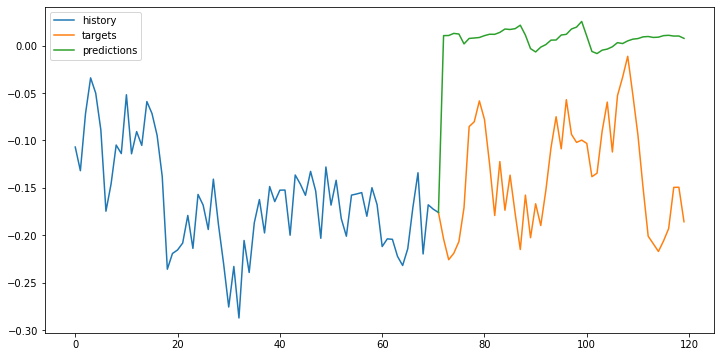

In [331]:
#model = tf.keras.models.load_model("model_weights/lstm_512_epochs20_alldata.h5")
#model.layers[0].input_shape
%autoreload
generator.predict_and_plot(model, test_df, start_pos=0)

[1.6 2.  2.4 2.  1.  0. ]
[1.6 2.  2.4 2.  1.  0. ]


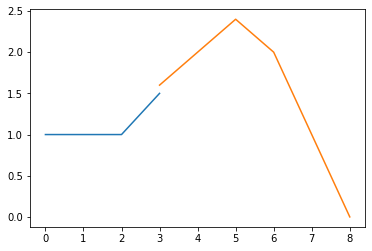

In [310]:

history = np.array([1,1,1,1.5])
predictions = np.array([1.6, 2, 2.4, 2, 1, 0])
n_predictions = len(predictions)
print(predictions)
#predictions = np.insert(predictions, 0, history[-1])
n_input = len(history)

print(predictions)
x = np.arange(len(history) + len(predictions))
plt.plot(x[:n_input], history, label="history")
plt.plot(x[n_input-1:-1], predictions, label="predictions")
plt.show()

In [329]:
np.concatenate(([history[-1]], predictions))

array([1.5, 1.6, 2. , 2.4, 2. , 1. , 0. ])